In [2]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from scipy.stats import ttest_ind
from scipy.stats import chisquare

In [4]:
plt.style.use('seaborn-poster')

In [5]:
fitCTX = h5py.File('./cortex-q2-log_rna_only-rand_init-batch/model-output-final.hdf5', 'r')
fitSVZ = h5py.File('./svz-q2-log_rna_only-rand_init-batch/model-output-final.hdf5', 'r')

In [6]:
f = h5py.File('../cortex_svz_combined.hdf5','r')

In [7]:
ctx_ix = range(524)
svz_ix = range(524,804)

In [8]:
nctx = len(ctx_ix)
nsvz = len(svz_ix)

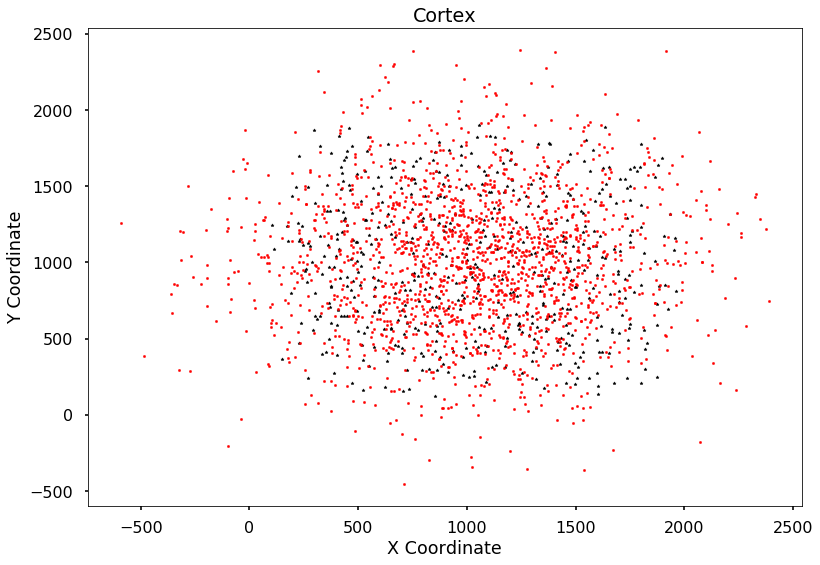

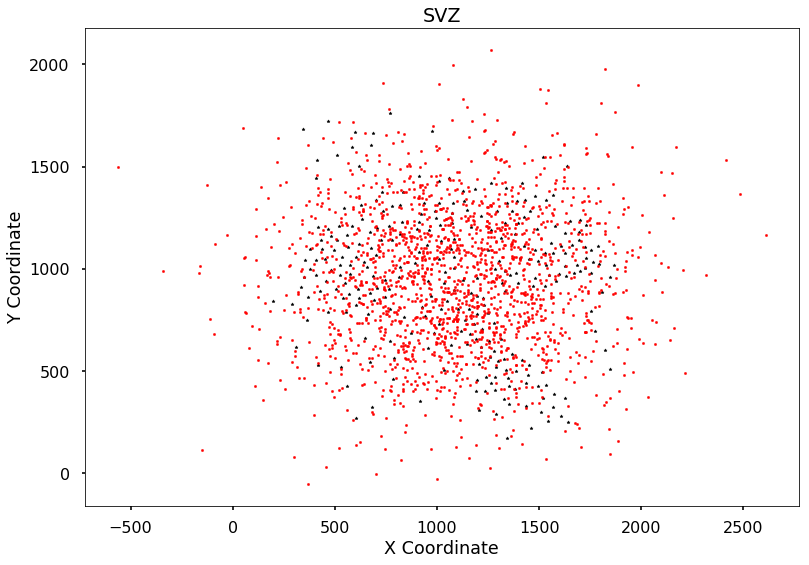

In [45]:

plt.scatter(f['coords'][ctx_ix,0],f['coords'][ctx_ix,1], s = 10.0, marker = '*', c = 'k', label = 'seqFISH+')
plt.scatter(100*fitCTX['zvar_init'][:,0],100*fitCTX['zvar_init'][:,1], s = 5.0, marker = 'o', c = 'r', label = 'scRNA-seq')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Cortex')
plt.show()


plt.scatter(f['coords'][svz_ix,0],f['coords'][svz_ix,1], s = 10.0, marker = '*', c = 'k', label = 'seqFISH+')
plt.scatter(100*fitSVZ['zvar_init'][:,0],100*fitSVZ['zvar_init'][:,1], s = 5.0, marker = 'o', c = 'r', label = 'scRNA-seq')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('SVZ')
plt.show()

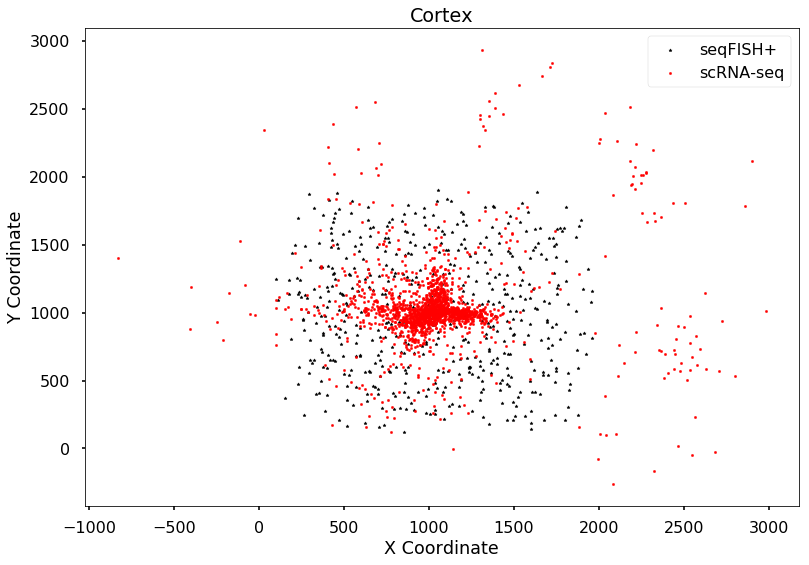

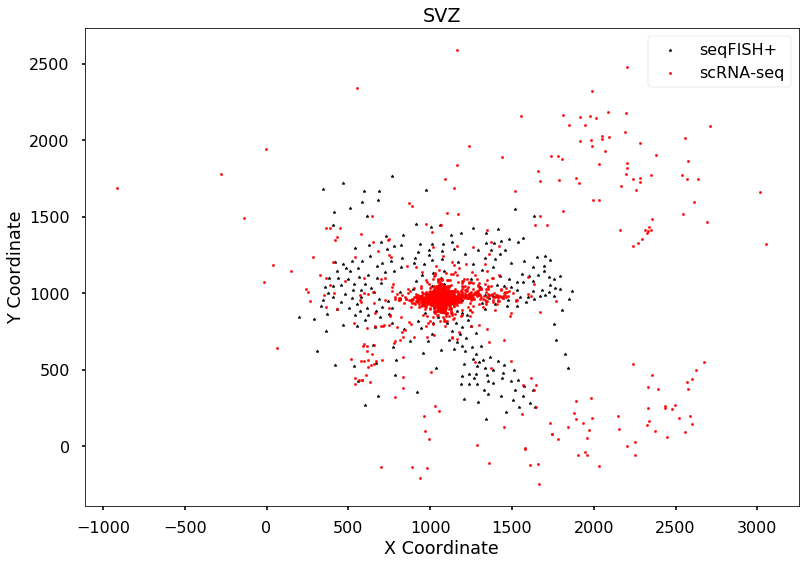

In [51]:

plt.scatter(f['coords'][ctx_ix,0],f['coords'][ctx_ix,1], s = 10.0, marker = '*', c = 'k', label = 'seqFISH+')
plt.scatter(100*fitCTX['z_post'][nctx:,0],100*fitCTX['z_post'][nctx:,1], s = 5.0, marker = 'o', c = 'r', label = 'scRNA-seq')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Cortex')
plt.legend()
plt.show()


plt.scatter(f['coords'][svz_ix,0],f['coords'][svz_ix,1], s = 10.0, marker = '*', c = 'k', label = 'seqFISH+')
plt.scatter(100*fitSVZ['z_post'][nsvz:,0],100*fitSVZ['z_post'][nsvz:,1], s = 5.0, marker = 'o', c = 'r', label = 'scRNA-seq')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('SVZ')
plt.legend()
plt.show()

In [11]:
celltype_annotations = pd.read_csv('../celltype_annotations/cortex_svz_cell_type_annotations.csv')

In [12]:
rna_seq = pd.read_csv('../GSE71585_RefSeq_counts.csv.gz')
meta = pd.read_csv('../GSE71585_Clustering_Results.csv.gz')
rna_seq_cells = rna_seq.columns[1:]
found = np.zeros(len(rna_seq_cells))

counter = 0
for i in rna_seq_cells:
    found[counter] = np.where(meta['sample_title'] == i)[0][0]
    #print(i)
    #print(rna_seq_cells[found[counter]])
    counter += 1
meta2 = meta.reindex(found)

In [13]:
from sklearn.neighbors import NearestNeighbors

In [14]:
ctx_max = np.max(fitCTX['z_post'][ctx_ix,], axis = 0)
ctx_min = np.min(fitCTX['z_post'][ctx_ix,], axis = 0)
mask_max = fitCTX['z_post'][nctx-1:] < ctx_max
mask_min = fitCTX['z_post'][nctx-1:] > ctx_min
mask1 = np.logical_and(mask_max, mask_min)
mask_ctx = np.logical_and(mask1[:,0],mask1[:,1])
np.sum(mask_ctx)

1691

In [15]:
z_ctx = fitCTX['z_post'][nctx-1:][mask_ctx]
labs_ctx = meta2['broad_type'].values[mask_ctx]

In [16]:
n_rna = len(np.unique(labs_ctx))
labs_rna = np.unique(labs_ctx)
fig_labels = np.hstack(('', labs_rna))

In [17]:
type_bar = meta2['broad_type'][mask_ctx].value_counts().index
type_counts = meta2['broad_type'][mask_ctx].value_counts().values
type_counts_sort = type_counts[np.argsort(type_bar)]
count_norm = type_counts_sort/float(np.sum(type_counts_sort))

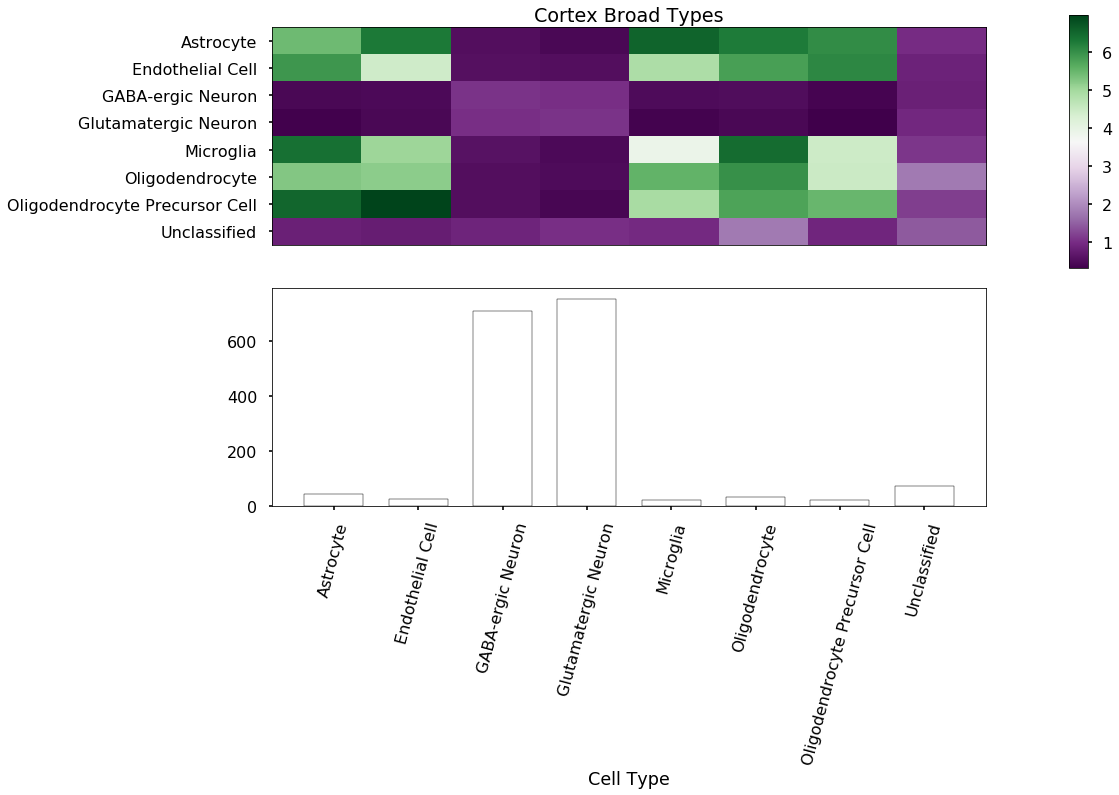

In [56]:
K = 15

knn = np.array(NearestNeighbors(n_neighbors = K).fit(z_ctx).kneighbors_graph().todense())
mnn = np.multiply(knn, knn.T)
contingencyMNN = np.zeros((n_rna, n_rna))

for i in range(z_ctx.shape[0]):
    i_nn = mnn[i,:]
    i_labs = labs_ctx[i_nn.astype(bool)]
    
    i_ix = np.where(labs_rna == labs_ctx[i])[0]
    
    for j in range(n_rna):
        maskj = i_labs == labs_rna[j]
        contingencyMNN[i_ix, j] += np.sum(maskj)
cmnnnorm = np.divide(contingencyMNN.T, np.sum(contingencyMNN, axis = 1)).T

fig, ax1 = plt.subplots(2,1)
im = ax1[0].imshow(np.divide(cmnnnorm,count_norm), cmap = 'PRGn', aspect = 'auto')
ax1[0].set_xticks(())
#ax1[0].set_xticklabels((''))
ax1[0].set_yticks(range(8))
ax1[0].set_yticklabels(labs_rna)
#fig.colorbar(im, ax=ax1[0])
im2 = ax1[1].bar(np.linspace(0.5,8.5,8), type_counts_sort, color = 'w', edgecolor = 'k')
ax1[1].set_xticks(np.linspace(0.5,8.5,8))
ax1[1].set_xticklabels(labs_rna, rotation = 75)
ax1[1].set_xlabel('Cell Type')

ax1[0].set_title('Cortex Broad Types')
cb_ax = fig.add_axes([0.99, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

plt.show()

In [19]:
chisquare(contingencyMNN, count_norm, axis = 1)

Power_divergenceResult(statistic=array([  525373.92651862,   203874.18578435, 77090583.27936874,
       88459372.80012284,   125408.8691202 ,   398118.08587696,
         131438.07222926,   691731.72562843]), pvalue=array([0., 0., 0., 0., 0., 0., 0., 0.]))

In [20]:
A = meta2['broad_type'][mask_ctx].value_counts().values
B = meta2['broad_type'].value_counts().values
C = np.divide(1. * A, B)

In [21]:
svz_max = np.max(fitSVZ['z_post'][:nsvz,], axis = 0)
svz_min = np.min(fitSVZ['z_post'][:nsvz,], axis = 0)
mask_max = fitSVZ['z_post'][nsvz-1:] < svz_max
mask_min = fitSVZ['z_post'][nsvz-1:] > svz_min
mask1 = np.logical_and(mask_max, mask_min)
mask_svz = np.logical_and(mask1[:,0],mask1[:,1])
np.sum(mask_svz)

1678

In [22]:
z_svz = fitSVZ['z_post'][nsvz-1:][mask_svz]
labs_svz = meta2['broad_type'].values[mask_svz]

In [23]:
type_bar = meta2['broad_type'][mask_svz].value_counts().index
type_counts = meta2['broad_type'][mask_svz].value_counts().values
type_counts_sort = type_counts[np.argsort(type_bar)]
count_norm = type_counts_sort/float(np.sum(type_counts_sort))

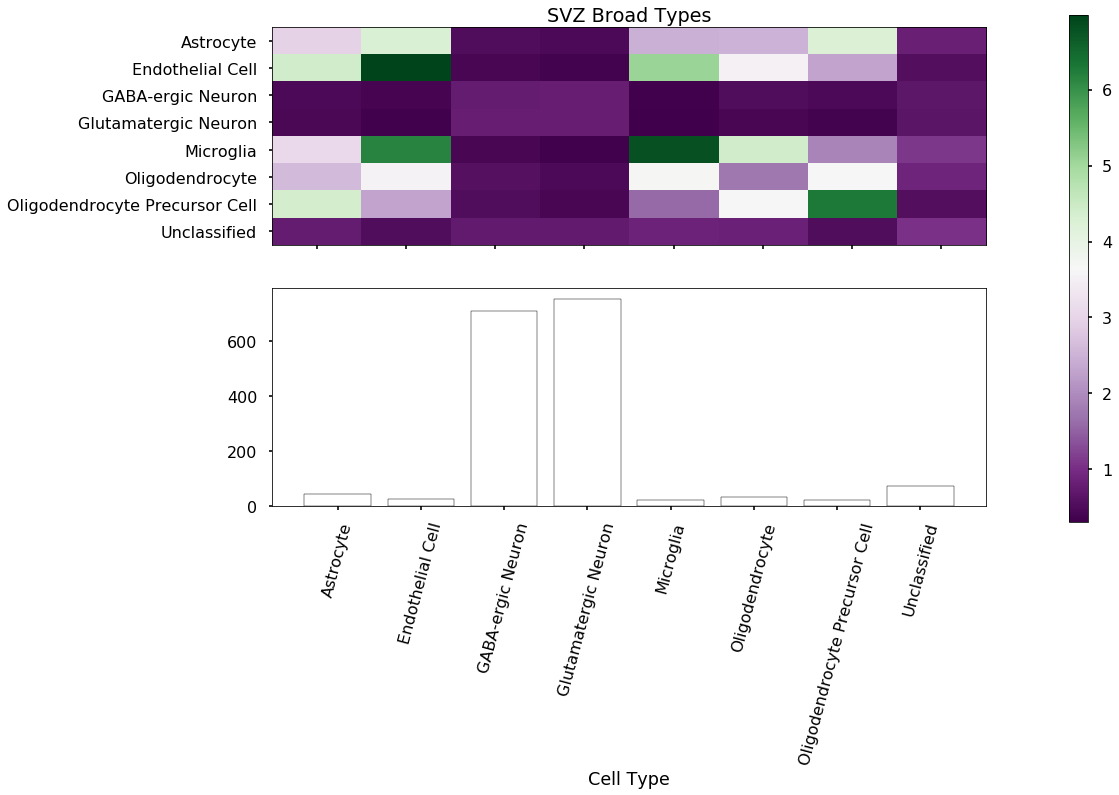

In [57]:
K = 15

knn = np.array(NearestNeighbors(n_neighbors = K).fit(z_svz).kneighbors_graph().todense())
mnn = np.multiply(knn, knn.T)
contingencyMNN = np.zeros((n_rna, n_rna))

for i in range(z_svz.shape[0]):
    i_nn = mnn[i,:]
    i_labs = labs_svz[i_nn.astype(bool)]
    
    i_ix = np.where(labs_rna == labs_svz[i])[0]
    
    for j in range(n_rna):
        maskj = i_labs == labs_rna[j]
        contingencyMNN[i_ix, j] += np.sum(maskj)
cmnnnorm = np.divide(contingencyMNN.T, np.sum(contingencyMNN, axis = 1)).T

fig, ax1 = plt.subplots(2,1)
ax1[0].imshow(np.divide(cmnnnorm,count_norm), cmap = 'PRGn', aspect = 'auto')
ax1[0].set_xticklabels((''))
ax1[0].set_yticks(range(8))
ax1[0].set_yticklabels(labs_rna)

ax1[1].bar(range(0,8), type_counts_sort, color = 'w', edgecolor = 'k')
ax1[1].set_xticklabels(fig_labels, rotation = 75)
#fig.colorbar()

ax1[1].set_xlabel('Cell Type')

ax1[0].set_title('SVZ Broad Types')
cb_ax = fig.add_axes([0.99, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

plt.show()

In [25]:
chisquare(contingencyMNN, count_norm, axis = 1)

Power_divergenceResult(statistic=array([  547899.04281344,   396190.8959877 , 72880663.29386143,
       86819722.9649029 ,   171801.71949403,   277521.14493379,
         208887.46360238,   626433.92392633]), pvalue=array([0., 0., 0., 0., 0., 0., 0., 0.]))

In [26]:
A = meta2['broad_type'][mask_svz].value_counts().values
B = meta2['broad_type'].value_counts().values
C = np.divide(1. * A, B)

In [27]:
meta2['broad_type'][mask_svz].value_counts()

Glutamatergic Neuron              753
GABA-ergic Neuron                 709
Unclassified                       73
Astrocyte                          41
Oligodendrocyte                    33
Endothelial Cell                   26
Oligodendrocyte Precursor Cell     22
Microglia                          21
Name: broad_type, dtype: int64

In [28]:
C

array([0.9273399 , 0.93166886, 0.8902439 , 0.95348837, 0.86842105,
       0.89655172, 1.        , 0.95454545])

In [29]:
in_v_out_ctx = ttest_ind(f['rna_shared'][mask_ctx,:].shape, f['rna_shared'][np.logical_not(mask_ctx),:], equal_var = False)
in_v_out_svz = ttest_ind(f['rna_shared'][mask_svz,:].shape, f['rna_shared'][np.logical_not(mask_svz),:], equal_var = False)

In [30]:
print(f['genes'][:][np.argsort(in_v_out_ctx[1])][0:10])
print(f['genes'][:][np.argsort(in_v_out_svz[1])][0:10])

['Impact' 'Cnr1' 'A1cf' 'Noxa1' 'Hoxa11' 'Nr1i2' 'Hoxa7' 'Hoxa9' 'Cd5'
 'Hoxb1']
['Impact' 'Cnr1' 'A1cf' 'Lypd3' 'Lyg2' 'Art5' 'Lrrc63' 'Fmo3' 'Fmo6'
 'Lrit1']


In [31]:
print(in_v_out_ctx[0][np.argsort(in_v_out_ctx[1])][0:10])
print(in_v_out_svz[0][np.argsort(in_v_out_svz[1])][0:10])

[-3.6257482 -1.1425316  1.430828   1.430828   1.430828   1.430828
  1.430828   1.430828   1.430828   1.430828 ]
[-3.6602008 -1.4937724  1.4268091  1.4268091  1.4268091  1.4268091
  1.4268091  1.4268091  1.4268091  1.4268091]


In [32]:
print(in_v_out_ctx[1][np.argsort(in_v_out_ctx[1])][0:10])
print(in_v_out_svz[1][np.argsort(in_v_out_svz[1])][0:10])

[0.09976126 0.35465106 0.3883283  0.3883283  0.3883283  0.3883283
 0.3883283  0.3883283  0.3883283  0.3883283 ]
[0.11148635 0.22714865 0.38916949 0.38916949 0.38916949 0.38916949
 0.38916949 0.38916949 0.38916949 0.38916949]


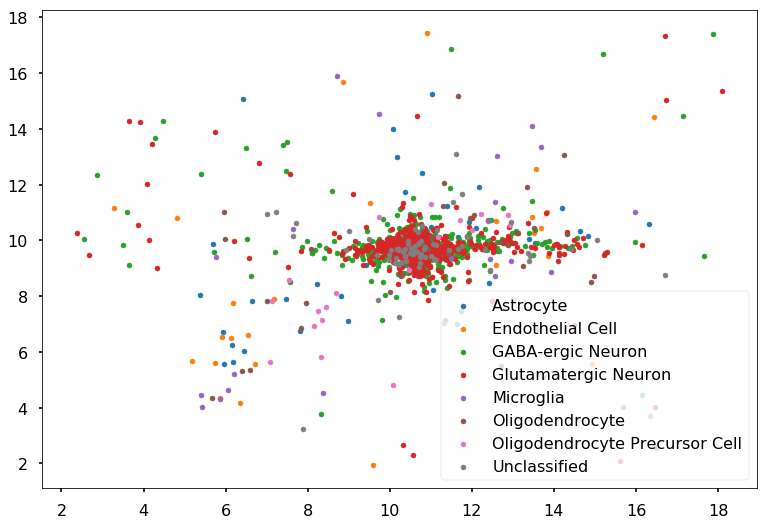

In [33]:
for i in np.unique(labs_svz):
    cmask = labs_svz == i
    plt.scatter(z_svz[cmask,0], z_svz[cmask,1], label = i, s = 25.0)
plt.legend()
plt.show()

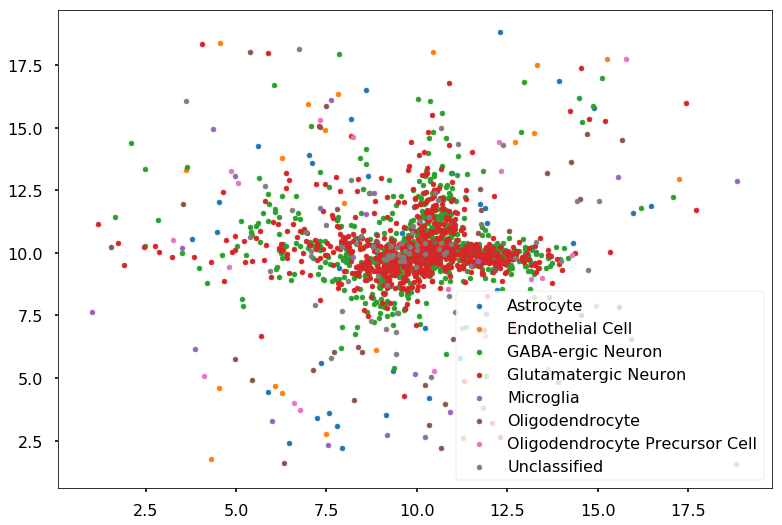

In [34]:
for i in np.unique(labs_ctx):
    cmask = labs_ctx == i
    plt.scatter(z_ctx[cmask,0], z_ctx[cmask,1], label = i, s = 25.0)
plt.legend()
plt.show()

In [35]:
fitCTX['x_mean'][nctx:].shape

(1808, 2)

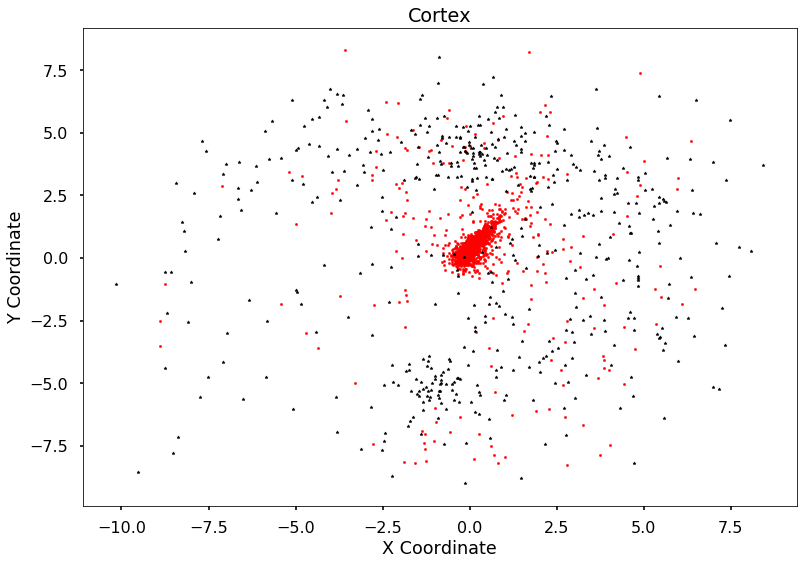

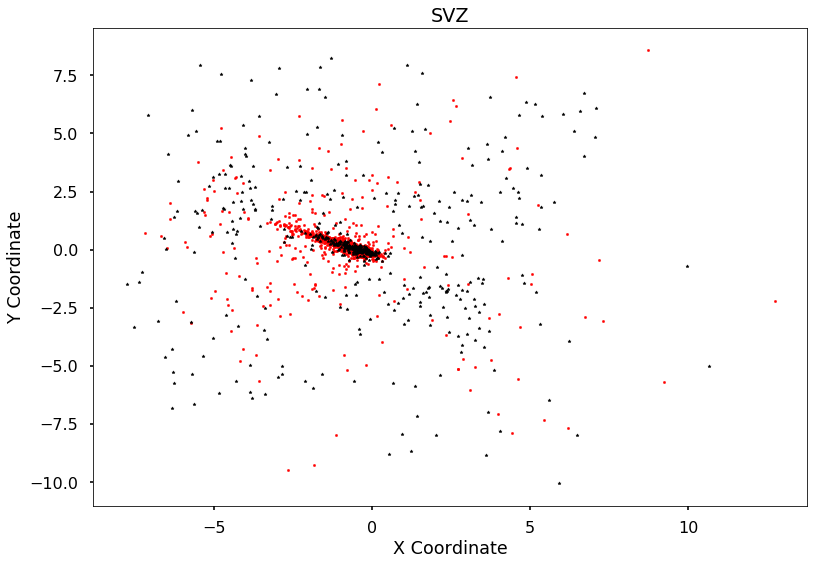

In [44]:
plt.scatter(fitCTX['x_mean'][nctx-1:,0],fitCTX['x_mean'][nctx-1:,1], s = 5.0, marker = 'o', c = 'r', label = 'seqFISH+')
plt.scatter(fitCTX['x_mean'][:nctx-1,0],fitCTX['x_mean'][:nctx-1,1], s = 10.0, marker = '*', c = 'k', label = 'scRNA-seq')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Cortex')
plt.show()

plt.scatter(fitSVZ['x_mean'][nctx-1:,0],fitSVZ['x_mean'][nctx-1:,1], s = 5.0, marker = 'o', c = 'r', label = 'seqFISH+')
plt.scatter(fitSVZ['x_mean'][:nctx-1,0],fitSVZ['x_mean'][:nctx-1,1], s = 10.0, marker = '*', c = 'k', label = 'scRNA-seq')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('SVZ')
plt.show()

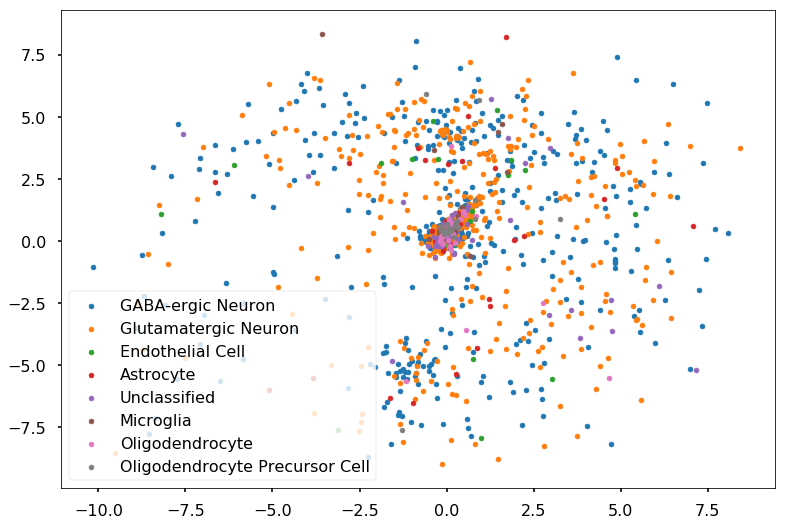

In [37]:
for i in meta2['broad_type'].unique():
    cmask = meta2['broad_type'].values == i
    plt.scatter(fitCTX['x_mean'][cmask,0], fitCTX['x_mean'][cmask,1], label = i, s = 25.0)
plt.legend()
plt.show()

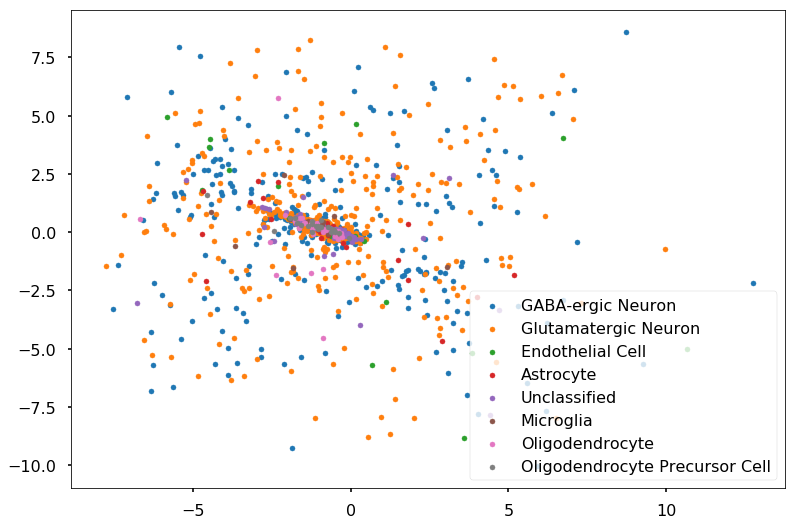

In [38]:
for i in meta2['broad_type'].unique():
    cmask = meta2['broad_type'].values == i
    plt.scatter(fitSVZ['x_mean'][cmask,0], fitSVZ['x_mean'][cmask,1], label = i, s = 25.0)
plt.legend()
plt.show()